Issues with widget output in last two cells (cannot see recommendations without this).


# Tutorial Using Book Crossing data

### https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847

In [385]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os, sys
import re
import seaborn as sns

In [386]:
books = pd.read_csv('books10k.csv')
books = books.drop(['image_url', 'small_image_url', 'title', 
                          'best_book_id'], axis = 1)
ratings = pd.read_csv('ratings10k.csv')

print(books.shape)
print(ratings.shape)

(10000, 19)
(230595, 3)


### Books data

In [387]:
books.head()

,book_id,goodreads_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317
1,2,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543
2,3,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439
3,4,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267
4,5,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718


In [388]:
books = books[books['original_title'].notna()]
books.shape

(9415, 19)

In [389]:
books.dtypes

book_id                        int64
goodreads_book_id              int64
work_id                        int64
books_count                    int64
isbn                          object
isbn13                       float64
authors                       object
original_publication_year    float64
original_title                object
language_code                 object
average_rating               float64
ratings_count                  int64
work_ratings_count             int64
work_text_reviews_count        int64
ratings_1                      int64
ratings_2                      int64
ratings_3                      int64
ratings_4                      int64
ratings_5                      int64
dtype: object

In [390]:
books = books[['book_id', 'original_title', 'authors', 'average_rating',
                'ratings_count', 'work_id', 'work_ratings_count', 'work_text_reviews_count',
                'books_count','isbn', 'isbn13', 'original_publication_year', 'language_code',
                'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5'
               ]]
books.head()

,book_id,original_title,authors,average_rating,ratings_count,work_id,work_ratings_count,work_text_reviews_count,books_count,isbn,isbn13,original_publication_year,language_code,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,The Hunger Games,Suzanne Collins,4.34,4780653,2792775,4942365,155254,272,439023483,9.780439e+12,2008.0,eng,66715,127936,560092,1481305,2706317
1,2,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré",4.44,4602479,4640799,4800065,75867,491,439554934,9.780440e+12,1997.0,eng,75504,101676,455024,1156318,3011543
2,3,Twilight,Stephenie Meyer,3.57,3866839,3212258,3916824,95009,226,316015849,9.780316e+12,2005.0,en-US,456191,436802,793319,875073,1355439
3,4,To Kill a Mockingbird,Harper Lee,4.25,3198671,3275794,3340896,72586,487,61120081,9.780061e+12,1960.0,eng,60427,117415,446835,1001952,1714267
4,5,The Great Gatsby,F. Scott Fitzgerald,3.89,2683664,245494,2773745,51992,1356,743273567,9.780743e+12,1925.0,eng,86236,197621,606158,936012,947718


In [391]:
books.shape

(9415, 18)

### Ratings data

In [392]:
ratings.shape

(230595, 3)

In [393]:
ratings.head()

,user_id,book_id,rating
0,1,258,5.0
1,2,4081,4.0
2,2,260,5.0
3,2,9296,5.0
4,2,2318,3.0


In [394]:
ratings['user_id'].nunique()

3788

In [395]:
ratings['book_id'].nunique()

5743

In [396]:
n_users = ratings['user_id'].nunique()
n_books = ratings['book_id'].nunique()
print(n_users*n_books)

21754484


In [397]:
ratings_new = ratings[ratings.book_id.isin(books.book_id)]

In [398]:
print(ratings.shape)
print(ratings_new.shape)

(230595, 3)
(228021, 3)


In [399]:
sparsity = 1.0 - len(ratings_new)/float(n_users*n_books)
print('The sparsity level of Goodreads 10k dataset is ' +
     str(sparsity*100) + '%')

The sparsity level of Goodreads 10k dataset is 98.95184367507866%


In [400]:
ratings_new.rating.value_counts()

4.0    82956
5.0    64377
3.0    59158
2.0    16576
1.0     4953
Name: rating, dtype: int64

In [401]:
ratings_new = ratings_new.fillna(0)
print(ratings_new.shape)

(228021, 3)


In [402]:
ratings_new.tail()

,user_id,book_id,rating
230590,5737,2724,5.0
230591,3904,10,5.0
230592,3904,1791,3.0
230593,3048,903,3.0
230594,3048,2259,0.0


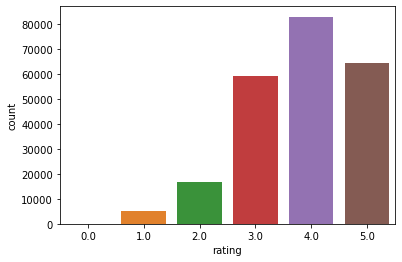

In [403]:
sns.countplot(data = ratings_new, x = "rating")
plt.show()

## Simple Popularity Based RS

In [404]:
ratings_count = pd.DataFrame(ratings_new.groupby(['book_id'])['rating'].sum())
top10 = ratings_count.sort_values('rating', ascending = False).head(10)
print("The following books are recommended:")
top10.merge(books, left_index = True, right_on = 'book_id')


The following books are recommended:


,rating,book_id,original_title,authors,average_rating,ratings_count,work_id,work_ratings_count,work_text_reviews_count,books_count,isbn,isbn13,original_publication_year,language_code,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
3,5600.0,4,To Kill a Mockingbird,Harper Lee,4.25,3198671,3275794,3340896,72586,487,61120081,9.780061e+12,1960.0,eng,60427,117415,446835,1001952,1714267
24,5179.0,25,Harry Potter and the Deathly Hallows,"J.K. Rowling, Mary GrandPré",4.61,1746574,2963218,1847395,51942,263,545010225,9.780545e+12,2007.0,eng,9363,22245,113646,383914,1318227
1,5103.0,2,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré",4.44,4602479,4640799,4800065,75867,491,439554934,9.780440e+12,1997.0,eng,75504,101676,455024,1156318,3011543
17,5068.0,18,Harry Potter and the Prisoner of Azkaban,"J.K. Rowling, Mary GrandPré, Rufus Beck",4.53,1832823,2402163,1969375,36099,376,043965548X,9.780440e+12,1999.0,eng,6716,20413,166129,509447,1266670
23,4937.0,24,Harry Potter and the Goblet of Fire,"J.K. Rowling, Mary GrandPré",4.53,1753043,3046572,1868642,31084,332,439139600,9.780439e+12,2000.0,eng,6676,20210,151785,494926,1195045
26,4898.0,27,Harry Potter and the Half-Blood Prince,"J.K. Rowling, Mary GrandPré",4.54,1678823,41335427,1785676,27520,275,439785960,9.780440e+12,2005.0,eng,7308,21516,136333,459028,1161491
20,4804.0,21,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré",4.46,1735368,2809203,1840548,28685,307,439358078,9.780439e+12,2003.0,eng,9528,31577,180210,494427,1124806
25,4658.0,26,The Da Vinci Code,Dan Brown,3.79,1447148,2982101,1557292,41560,350,307277674,9.780307e+12,2003.0,eng,71345,126493,340790,539277,479387
22,4608.0,23,Harry Potter and the Chamber of Secrets,"J.K. Rowling, Mary GrandPré",4.37,1779331,6231171,1906199,34172,398,439064864,9.780439e+12,1998.0,eng,8253,42251,242345,548266,1065084
7,4529.0,8,The Catcher in the Rye,J.D. Salinger,3.79,2044241,3036731,2120637,44920,360,316769177,9.780317e+12,1951.0,eng,109383,185520,455042,661516,709176


## Collaborative Filtering Based RS

In [405]:
# https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-the-fundamentals-dfee054f978e
# https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Recommender%20Systems%20-%20The%20Fundamentals.ipynb


In [406]:
# trim down data to books and users with at least 3 ratings each
counts1 = ratings_new['user_id'].value_counts()
ratings_new2 = ratings_new[ratings_new['user_id'].
                                    isin(counts1[counts1 >= 3].index)]
counts = ratings_new['book_id'].value_counts()
ratings_new2 = ratings_new2[ratings_new2['rating'].
                                   isin(counts[counts >= 3].index)]

In [407]:
ratings_new2.shape # USE THIS to control whether the RS focuses on FL or BL

(222880, 3)

In [408]:
average_rating = pd.DataFrame(ratings_new2.groupby('book_id')['rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings_new2.groupby('book_id')['rating'].count())
average_rating.sort_values('ratingCount', ascending = False).head()

,rating,ratingCount
book_id,,
26,3.513534,1293
4,4.378527,1276
2,4.097502,1241
18,4.208819,1202
23,3.898981,1178


In [409]:
ratings_matrix = ratings_new2.pivot(index = 'user_id',
                                       columns = 'book_id', values = 'rating')
user_id = ratings_matrix.index
book_id = ratings_matrix.columns
ratings_matrix.head()

book_id,1,2,3,4,5,7,8,9,10,11,...,9984,9985,9986,9988,9990,9991,9995,9997,9998,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,5.0,NaN,4.0,4.0,4.0,4.0,NaN,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [410]:
n_users = ratings_matrix.shape[0]
n_books = ratings_matrix.shape[1]
print(n_users, n_books) # original ratings was 3788 x 5743

3662 5607


In [411]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)
ratings_matrix.head(5)

book_id,1,2,3,4,5,7,8,9,10,11,...,9984,9985,9986,9988,9990,9991,9995,9997,9998,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,5,0,0,0,0,4,5,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,5,0,4,4,4,4,0,5,4,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,3,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [412]:
ratings_matrix[4]

user_id
1       5
2       0
3       3
4       4
7       0
       ..
5758    0
5760    4
5766    4
6840    0
7582    0
Name: 4, Length: 3662, dtype: int32

In [413]:
ratings_matrix.loc[3]

book_id
1        0
2        0
3        0
4        3
5        0
        ..
9991     0
9995     0
9997     0
9998     0
10000    0
Name: 3, Length: 5607, dtype: int32

### Item Based Collaborative Filter

In [414]:
# look at books correlated to #1 book on popular list (To Kill a Mockingbird)
mock_ratings = ratings_matrix[4]
similar_to_mock = ratings_matrix.corrwith(mock_ratings)
corr_mock = pd.DataFrame(similar_to_mock, columns = ['pearsonR'])
corr_summary = corr_mock.join(average_rating['ratingCount'])
corr_summary = corr_summary.sort_values('pearsonR', ascending = False)
# corr_summary2 = corr_summary[corr_summary['ratingCount'] >= 300].sort_values('pearsonR', ascending = False)
# do not need to filter because results are the same

In [415]:
mock_top10 = corr_summary.iloc[1:11]
mock_top10

,pearsonR,ratingCount
book_id,,
8,0.388486,1136
5,0.373973,1128
32,0.352613,851
28,0.351022,940
58,0.299237,829
14,0.280775,915
50,0.280268,786
2,0.275238,1241
10,0.272910,871


In [416]:
# top 10 recommendations based on interactions and pearsonsR correlation (ratings, users, books)
mock_recs = mock_top10.merge(books2, left_index = True, right_on = 'book_id')
mock_recs

,pearsonR,ratingCount,book_id,original_title,authors,average_rating,ratings_count,work_id,work_ratings_count,work_text_reviews_count,books_count,isbn,isbn13,original_publication_year,language_code,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
7,0.388486,1136,8,The Catcher in the Rye,J.D. Salinger,3.79,2044241,3036731,2120637,44920,360,316769177,9.780317e+12,1951.0,eng,109383,185520,455042,661516,709176
4,0.373973,1128,5,The Great Gatsby,F. Scott Fitzgerald,3.89,2683664,245494,2773745,51992,1356,743273567,9.780743e+12,1925.0,eng,86236,197621,606158,936012,947718
31,0.352613,851,32,Of Mice and Men,John Steinbeck,3.84,1467496,40283,1518741,24642,373,142000671,9.780142e+12,1937.0,eng,46630,110856,355169,532291,473795
27,0.351022,940,28,Lord of the Flies,William Golding,3.64,1605019,2766512,1671484,26886,458,140283331,9.780140e+12,1954.0,eng,92779,160295,425648,564916,427846
57,0.299237,829,58,The Adventures of Huckleberry Finn,"Mark Twain, John Seelye, Guy Cardwell",3.80,953758,1835605,1001491,12448,2277,142437174,9.780142e+12,1884.0,eng,28467,76630,255722,344356,296316
13,0.280775,915,14,Animal Farm: A Fairy Story,George Orwell,3.87,1881700,2207778,1982987,35472,896,452284244,9.780452e+12,1945.0,eng,66854,135147,433432,698642,648912
49,0.280268,786,50,Where the Sidewalk Ends: The Poems and Drawings of Shel Silverstein,Shel Silverstein,4.29,1016888,30518,1023781,9234,45,60513039,9.780061e+12,1974.0,eng,16590,30792,139024,293222,544153
1,0.275238,1241,2,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré",4.44,4602479,4640799,4800065,75867,491,439554934,9.780440e+12,1997.0,eng,75504,101676,455024,1156318,3011543
9,0.272910,871,10,Pride and Prejudice,Jane Austen,4.24,2035490,3060926,2191465,49152,3455,679783261,9.780680e+12,1813.0,eng,54700,86485,284852,609755,1155673
12,0.270586,978,13,Nineteen Eighty-Four,"George Orwell, Erich Fromm, Celâl Üster",4.14,1956832,153313,2053394,45518,995,451524934,9.780452e+12,1949.0,eng,41845,86425,324874,692021,908229


In [427]:
# write a function to do it all
def pearsonR_item(book_id, num, ratings = ratings_matrix, 
               average = average_rating, books = books):
    
    '''book_id is found in books or ratings df
    num is # of desired recommendations
    ratings requires df built as matrix of ratings, user_id x book_id
    average requires df built to contain book_id, rating, ratingCount
    books requires df from books10k.csv'''
    
    #i = num + 1 # index based on number of desired recommendations
    book_loc = ratings[book_id]
    similar = ratings.corrwith(book_loc)
    df = pd.DataFrame(similar, columns = ['pearsonR'])
    summary = df.join(average['ratingCount'])
    summary = pd.DataFrame(summary.sort_values('pearsonR', ascending = False))
    #book = summary.loc[0]['original_title']
    recs = summary.iloc[:num] # skip first record since it is original book_id
    
    #return print("If you like ", + book + " , then you should read:")
    return recs.merge(books, left_index = True, right_on = 'book_id')
    # corrwith() computes pairwise correlation

In [429]:
pearsonR_item(4, 5)

,pearsonR,ratingCount,book_id,original_title,authors,average_rating,ratings_count,work_id,work_ratings_count,work_text_reviews_count,books_count,isbn,isbn13,original_publication_year,language_code,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
3,1.000000,1276,4,To Kill a Mockingbird,Harper Lee,4.25,3198671,3275794,3340896,72586,487,61120081,9.780061e+12,1960.0,eng,60427,117415,446835,1001952,1714267
7,0.388486,1136,8,The Catcher in the Rye,J.D. Salinger,3.79,2044241,3036731,2120637,44920,360,316769177,9.780317e+12,1951.0,eng,109383,185520,455042,661516,709176
4,0.373973,1128,5,The Great Gatsby,F. Scott Fitzgerald,3.89,2683664,245494,2773745,51992,1356,743273567,9.780743e+12,1925.0,eng,86236,197621,606158,936012,947718
31,0.352613,851,32,Of Mice and Men,John Steinbeck,3.84,1467496,40283,1518741,24642,373,142000671,9.780142e+12,1937.0,eng,46630,110856,355169,532291,473795
27,0.351022,940,28,Lord of the Flies,William Golding,3.64,1605019,2766512,1671484,26886,458,140283331,9.780140e+12,1954.0,eng,92779,160295,425648,564916,427846


In [372]:
books[books['original_title'] == 'The Name of the Wind']

,book_id,original_title,authors,average_rating,ratings_count,work_id,work_ratings_count,work_text_reviews_count,books_count,isbn,isbn13,original_publication_year,language_code,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
191,192,The Name of the Wind,Patrick Rothfuss,4.55,400101,2502879,449372,28631,123,075640407X,9.780756e+12,2007.0,eng,5605,8582,28480,95470,311235


In [373]:
pearsonR_item(192, 10) # why does this only pull 9 recs?

,pearsonR,ratingCount,book_id,original_title,authors,average_rating,ratings_count,work_id,work_ratings_count,work_text_reviews_count,books_count,isbn,isbn13,original_publication_year,language_code,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
5427,0.347179,1,5428,"Dauntless (The Lost Fleet, #1)",Jack Campbell,3.93,19074,108122,21316,1207,32,441014186,9.780441e+12,2006.0,NaN,271,1048,4742,9006,6249
8134,0.347179,1,8135,"Fearless (The Lost Fleet, #2)",Jack Campbell,3.97,12733,93102,14477,457,27,441014763,9.780441e+12,2007.0,NaN,71,481,3313,6537,4075
6930,0.277289,2,6931,Lord John and the Brotherhood of the Blade,Diana Gabaldon,3.86,14952,1612336,17164,797,42,385337493,9.780385e+12,2007.0,en-US,271,918,4658,6402,4915
2188,0.263714,7,2189,The Ghost Brigades,John Scalzi,4.09,40107,18279845,47619,2378,45,765354063,9.780765e+12,2006.0,en-GB,141,812,8443,23499,14724
909,0.246975,10,910,Old Man's War,John Scalzi,4.23,97653,50700,109133,6878,64,765348276,9.780765e+12,2005.0,eng,883,2704,14821,42929,47796
8293,0.235500,3,8294,The Android's Dream,John Scalzi,3.97,11476,18280036,13653,1284,14,765309416,9.780765e+12,2006.0,en-US,139,456,2947,6299,3812
3012,0.180845,4,3013,The Last Colony,John Scalzi,4.03,29154,18279847,35957,1724,33,765316978,9.780765e+12,2007.0,en-US,115,761,7306,17444,10331
6374,0.180695,5,6375,The First Man in Rome,Colleen McCullough,4.08,15362,2564369,16607,732,57,380710811,9.780381e+12,1990.0,eng,409,827,2758,5573,7040
9464,0.177943,2,9465,"Ultimate Spider-Man, Volume 1: Power and Responsibility","Brian Michael Bendis, Mark Bagley",4.06,10462,102101,10929,268,24,078510786X,9.780785e+12,2001.0,eng,225,531,2105,3607,4461


In [430]:
books[books['authors'] == 'Tana French']

,book_id,original_title,authors,average_rating,ratings_count,work_id,work_ratings_count,work_text_reviews_count,books_count,isbn,isbn13,original_publication_year,language_code,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
472,473,In the Woods,Tana French,3.74,188024,3088141,201721,15392,78,670038601,9.780670e+12,2007.0,eng,6553,15636,51430,77182,50920
1324,1325,The Likeness,Tana French,4.05,72480,6504351,80243,6945,56,670018864,9.780670e+12,2008.0,eng,915,2856,14814,34478,27180
1910,1911,Faithful Place,Tana French,3.97,55355,7350661,61097,5736,65,670021873,9.780670e+12,2010.0,eng,584,2205,13196,27712,17400
2206,2207,Broken Harbor,Tana French,3.92,36704,15718578,50491,5418,2,1444705105,9.781445e+12,2012.0,eng,573,2100,11404,22954,13460
2887,2888,The Secret Place,Tana French,3.83,30834,21598636,38667,4883,44,670026328,9.780670e+12,2014.0,eng,729,2363,9360,16607,9608


In [431]:
average_rating.iloc[1473]

rating          3.666667
ratingCount    24.000000
Name: 2219, dtype: float64

In [433]:
pearsonR_item(473, 10)

,pearsonR,ratingCount,book_id,original_title,authors,average_rating,ratings_count,work_id,work_ratings_count,work_text_reviews_count,books_count,isbn,isbn13,original_publication_year,language_code,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
472,1.000000,9,473,In the Woods,Tana French,3.74,188024,3088141,201721,15392,78,670038601,9.780670e+12,2007.0,eng,6553,15636,51430,77182,50920
1324,0.347811,1,1325,The Likeness,Tana French,4.05,72480,6504351,80243,6945,56,670018864,9.780670e+12,2008.0,eng,915,2856,14814,34478,27180
8672,0.347811,1,8673,Raven Black,Ann Cleeves,3.85,10617,2327400,14283,1405,40,312359667,9.780312e+12,2006.0,en-US,190,682,3596,6447,3368
6769,0.271125,2,6770,Lullabies for Little Criminals,Heather O'Neill,3.95,14535,23263,15087,1238,32,60875070,9.780061e+12,2006.0,eng,232,798,3177,6157,4723
8225,0.245401,2,8226,The Woodlanders,"Thomas Hardy, Patricia Ingham",3.82,10835,2502604,11642,381,230,140435476,9.780140e+12,1887.0,eng,337,700,2965,4313,3327
2010,0.240244,4,2011,Snuff,Chuck Palahniuk,3.18,43496,2034926,46968,2564,59,385517882,9.780386e+12,2008.0,en-US,3063,8963,17291,11797,5854
8718,0.216673,2,8719,"The Man With a Load of Mischief (Richard Jury Mystery, #1)",Martha Grimes,4.01,11947,3114345,12431,385,25,451410815,9.780451e+12,1981.0,eng,230,488,2547,4824,4342
5714,0.216449,3,5715,The Venetian Betrayal,Steve Berry,3.94,18403,2979692,19834,789,54,345485777,9.780345e+12,2007.0,en-US,195,786,4737,8330,5786
9198,0.203646,6,9199,The Third Secret,Steve Berry,3.84,10809,72567,12179,622,55,345476131,9.780345e+12,2005.0,eng,185,687,3291,4725,3291
7246,0.186317,4,7247,Sepulchre,Kate Mosse,3.73,13368,1027521,15790,1253,81,752860550,9.780753e+12,2007.0,en-GB,351,1275,4473,5818,3873


### User Based Collaborative Filter

In [ ]:
# pearsonR does not work for users (why?)

In [259]:
user_rating = pd.DataFrame(ratings_new.groupby('user_id')['rating'].mean())
user_rating['ratingCount'] = pd.DataFrame(ratings_new.groupby('user_id')['rating'].count())
user_rating.sort_values('ratingCount', ascending = False).head()

,rating,ratingCount
user_id,,
5272,3.731183,186
5436,3.675676,185
2276,3.524324,185
4606,3.717391,184
4147,3.832402,179


In [284]:
top_user = pd.DataFrame(ratings_matrix.loc[5272])
top_user.head()

,5272
book_id,
2,0
3,5
4,0
5,0
7,0


In [285]:
top_user[(top_user.T != 0).any()]

,5272
book_id,
3,5
10,3
15,5
22,5
32,2
...,...
7110,4
7353,4
8168,4


In [289]:
books2[books2['book_id'] == 10]


,book_id,original_title,authors,average_rating,ratings_count,work_id,work_ratings_count,work_text_reviews_count,books_count,isbn,isbn13,original_publication_year,language_code,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
9,10,Pride and Prejudice,Jane Austen,4.24,2035490,3060926,2191465,49152,3455,679783261,9.780680e+12,1813.0,eng,54700,86485,284852,609755,1155673


In [293]:
similar_users = ratings_matrix.corrwith(top_user)
df = pd.DataFrame(ratings_matrix.corrwith(top_user), columns = ['pearsonR'])
df.head()

,pearsonR
2,NaN
3,NaN
4,NaN
5,NaN
7,NaN


In [274]:
# write a function to do it all
def pearsonR_user(user_id, num, ratings = ratings_matrix, 
               average = user_rating, books = books2):
    
    '''user_id is found in ratings df
    num is # of desired recommendations
    ratings requires df built as matrix of ratings, user_id x book_id
    average requires df built to contain user_id, rating, ratingCount
    books requires df from books10k.csv'''
    
    user_loc = ratings.loc[user_id]
    similar = ratings.corrwith(user_loc) # find similar users
    df = pd.DataFrame(similar, columns = ['pearsonR'])
    summary = df.join(average['ratingCount'])
    summary = summary.sort_values('pearsonR', ascending = False)
    recs = summary.iloc[0:num] # this time, result is list of users
    
    return recs
    # return recs.merge(books, left_index = True, right_on = 'book_id')
    # corrwith() computes pairwise correlation

In [275]:
pearsonR_user(5272, 10) # strange output?

,pearsonR,ratingCount
book_id,,
8336,0.204226,NaN
3398,0.152496,31.0
9858,0.150989,NaN
6264,0.144884,NaN
8035,0.144884,NaN
8842,0.144884,NaN
7568,0.144884,NaN
1929,0.144884,NaN
8632,0.144884,NaN
